# Fits and characterizes final model for version v5 for outcome

pp_hybrid_wk4_outcome

Gaylen Fronk  
April 23, 2024

### Set Up Environment

In [ ]:
study <- params$study
version <- params$version
cv <- params$cv
algorithms <- params$algorithms
y_col_name <- params$y_col_name


Packages for script

In [ ]:

library(tidymodels)


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ recipes      1.0.9
✔ dials        1.2.0     ✔ rsample      1.2.0
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.4.4     ✔ tidyr        1.3.1
✔ infer        1.0.6     ✔ tune         1.1.2
✔ modeldata    1.3.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ stringr::fixed()    masks recipes::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ readr::spec()       masks yardstick::spec()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

here() starts at C:/Users/gfronk/Documents/GitHub/study_match

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "bb7bddab14e337e74cb65ad3b94d58a2492d34cd"

Handle conflicts

In [ ]:

options(conflicts.policy = "depends.ok")


Absolute paths

In [ ]:
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_input <- stringr::str_c("P:/studydata/match/chtc/", 
                                       y_col_name)
          path_models <- stringr::str_c("P:/studydata/match/models/", 
                                        y_col_name)},
        
        # IOS paths
        Darwin = {
          path_input <- stringr::str_c("/Volumes/private/studydata/match/chtc/", 
                                       y_col_name)
          path_models <- stringr::str_c("/Volumes/private/studydata/match/models/", 
                                        y_col_name)},
        
        # Linux paths
        Linux = {
          path_input <- stringr::str_c("~/mnt/private/studydata/match/chtc/", 
                                       y_col_name)
          path_models <- stringr::str_c("~/mnt/private/studydata/match/models/", 
                                        y_col_name)}
)


Chunk Defaults

In [ ]:

knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)


### Read in best configuration

Selected in 1_metrics_inner (k-fold CV)

In [ ]:
best_config <- read_csv(file.path(path_models, 
                                  str_c("best_config_", version, ".csv")),
                        show_col_types = FALSE)

glimpse(best_config)


Rows: 1
Columns: 14
$ n_jobs       <dbl> 10
$ algorithm    <chr> "glmnet"
$ feature_set  <chr> "item_ordinal"
$ hp1          <dbl> 0.1
$ hp2          <dbl> 0.1326421
$ hp3          <lgl> NA
$ resample     <chr> "up_1"
$ accuracy     <dbl> 0.6651376
$ bal_accuracy <dbl> 0.6535065
$ roc_auc      <dbl> 0.7358708
$ sens         <dbl> 0.6524493
$ spec         <dbl> 0.6377969
$ ppv          <dbl> 0.4682609
$ npv          <dbl> 0.7860704

### Fit best model in full dataset

In [ ]:
batch_names <- list.dirs(path_input, full.names = FALSE, recursive = FALSE) 

batch_name <- batch_names[str_detect(batch_names, "train") & 
                            str_detect(batch_names, cv) &
                            str_detect(batch_names, version) &
                            str_detect(batch_names, best_config$algorithm)] 

path_batch <- file.path(path_input, batch_name)
source(file.path(path_batch, "input", "training_controls.R"))

d <- read_csv(file.path(path_batch, "input", "data_trn.csv"), 
              show_col_types = FALSE) 

d_outcomes <- d |> 
  select(subid, ends_with("outcome") & contains("hybrid"))

d <- format_data(d) 

rec <- build_recipe(d = d, config = best_config)

rec_prepped <- rec |> 
  prep(training = d, strings_as_factors = FALSE)

feat_all <- rec_prepped |> 
  bake(new_data = d)

model_best <- fit_best_model(best_model = best_config, 
                             feat = feat_all, 
                             ml_mode = "classification")


### Model coefficients

**NOTE**: Coefficients are naturally inverted (i.e., positive class \[abstinence\] treated as first \[vs. second\] class). Here, we multiply coefficients by -1 to align the direction of coefficients with the rest of our analyses. Once flipped (i.e., as they appear below)…

A *positive coefficient* indicates that increases in the feature *increase* the likelihood of abstinence. For example, increases in motivation to quit (“motive_quit_order”) *increase* the likelihood of abstinence.

A *negative coefficient* indicates that increases in the feature *decrease* the likelihood of smoking. For example, increases in carbon monoxide (“co”) *decrease* the likelihood of abstinence.

In [ ]:
model_tidy <- tidy(model_best)


Loaded glmnet 4.1-8

In [ ]:
retained_vars <- model_tidy |> 
  mutate(estimate = estimate * -1) |> 
  filter(abs(estimate) > 0) |> 
  select(-penalty) |> 
  arrange(desc(abs(estimate)))

print_kbl(retained_vars, digits = 4)


10.91% of features were retained by the glmnet solution (128 features of a total considered 1173 features).

In [ ]:
retained_vars_tx <- retained_vars |> 
  filter(str_detect(term, "treatment_")) |> 
  arrange(desc(abs(estimate))) 

print_kbl(retained_vars_tx, digits = 4)


43.75% of the retained features were treatment interaction features (56 treatment features of 128 retained features). Of the 879 available treatment interaction features, 6% were retained.

### Calculate and calibrate probabilities

Make triplicate dataset

In [ ]:
d_patch <- d |> 
  mutate(treatment = "patch") 

d_combo <- d |> 
  mutate(treatment = "combo_nrt")

d_varen <- d |> 
  mutate(treatment = "varenicline")

d_trip <- bind_rows(d_patch, d_combo) |> 
  bind_rows(d_varen) |> 
  mutate(treatment = factor(treatment, 
                            levels = c(
                              "patch",
                              "varenicline",
                              "combo_nrt")))


Build triplicate feature set

In [ ]:
feat_trip <- rec_prepped |> 
  bake(new_data = d_trip) 


Get raw and calibrated probabilities

In [ ]:
# raw (uncalibrated) predictions for triplicated dataset
preds_prob <- predict(model_best, feat_trip,
                      type = "prob")

# fit calibration model
set.seed(2468)
cal_split <- d |> 
  initial_split(prop = 3/4, strata = y)
d_cal_in <- training(cal_split) 
d_cal_out <- testing(cal_split)

rec_cal_prepped <- rec |> 
  prep(training = d_cal_in, strings_as_factors = FALSE)

feat_cal_in <- rec_cal_prepped |> 
  bake(new_data = NULL) 

feat_cal_out <- rec_cal_prepped |> 
  bake(new_data = d_cal_out) 

model_cal <- fit_best_model(best_config, feat = feat_cal_in, "classification")

# beta calibration
beta <- predict(model_cal, feat_cal_out,
                type = "prob") |>
  mutate(truth = feat_cal_out$y) |>
  cal_estimate_beta(truth = truth,
                    estimate = dplyr::starts_with(".pred_"),
                    smooth = TRUE)
preds_prob_beta <- preds_prob |>
  cal_apply(beta)

# iso calibration
iso <- predict(model_cal, feat_cal_out,
               type = "prob") |>
  mutate(truth = feat_cal_out$y) |>
  cal_estimate_isotonic(truth = truth,
                        estimate = dplyr::starts_with(".pred_"))
preds_prob_iso <- preds_prob |>
  cal_apply(iso)

# logistic calibration
logi <- predict(model_cal, feat_cal_out,
                type = "prob") |>
  mutate(truth = feat_cal_out$y) |>
  cal_estimate_logistic(truth = truth,
                        estimate = dplyr::starts_with(".pred_"),
                        smooth = TRUE)
preds_prob_logi <- preds_prob |>
  cal_apply(logi)

# combine raw and calibrated probs
probs <- tibble(subid = d_trip$subid,
                tx = d_trip$treatment,
                prob_raw = preds_prob[[str_c(".pred_", y_level_pos)]],
                prob_beta = preds_prob_beta[[str_c(".pred_", y_level_pos)]],
                prob_iso = preds_prob_iso[[str_c(".pred_", y_level_pos)]],
                prob_logi = preds_prob_logi[[str_c(".pred_", y_level_pos)]]) 

glimpse(probs)


Rows: 3,258
Columns: 6
$ subid     <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 20086, 2010…
$ tx        <fct> patch, patch, patch, patch, patch, patch, patch, patch, patc…
$ prob_raw  <dbl> 0.2007715, 0.4175508, 0.2309921, 0.3847692, 0.3137408, 0.360…
$ prob_beta <dbl> 0.1513093, 0.3453291, 0.1799548, 0.3184819, 0.2567222, 0.297…
$ prob_iso  <dbl> 0.0000000, 0.2222222, 0.0000000, 0.2222222, 0.2222222, 0.222…
$ prob_logi <dbl> 0.1235681, 0.3712996, 0.1779860, 0.3691958, 0.3225351, 0.361…

### Make AIM 2 Dataset

Pivot probabilities into wide format & select only raw probability (based on calibration validity check below)

In [ ]:
raw_probs_wide <- probs |> 
  select(subid, tx, prob_raw) |> 
  pivot_wider(names_prefix = "prob_",
              names_from = tx,
              values_from = prob_raw)

glimpse(raw_probs_wide)


Rows: 1,086
Columns: 4
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ prob_patch       <dbl> 0.2007715, 0.4175508, 0.2309921, 0.3847692, 0.3137408…
$ prob_combo_nrt   <dbl> 0.1845281, 0.4643572, 0.3136065, 0.3954174, 0.4326885…
$ prob_varenicline <dbl> 0.2646638, 0.4846121, 0.2747510, 0.4322435, 0.4224485…

Join with d & create new variables

In [ ]:
d_aim_2 <- d |> 
  select(subid, tx_rct = treatment, outcome_rct_wk4 = y) |> 
  left_join(raw_probs_wide, by = "subid") |> 
  mutate(tx_best = case_when(
    prob_patch > prob_combo_nrt & prob_patch > prob_varenicline ~ "patch",
    prob_combo_nrt > prob_patch & prob_combo_nrt > prob_varenicline ~ "combo_nrt",
    prob_varenicline > prob_patch & prob_varenicline > prob_combo_nrt ~ "varenicline",
    TRUE ~ NA_character_
  )) |> 
  mutate(prob_best = case_when(
    tx_best == "patch" ~ prob_patch,
    tx_best == "combo_nrt" ~ prob_combo_nrt,
    tx_best == "varenicline" ~ prob_varenicline,
    TRUE ~ NA_real_
  )) |> 
  mutate(tx_best = factor(tx_best, 
                          levels = c(
                            "patch",
                            "varenicline",
                            "combo_nrt"))) |> 
  mutate(tx_match = if_else(tx_best == tx_rct, TRUE, FALSE)) |> 
  left_join(d_outcomes, by = "subid") |> 
  select(-pp_hybrid_wk4_outcome, -pp_hybrid_wk1_outcome, -pp_hybrid_yr3_outcome) |> # already in there from d
  rename(outcome_rct_wk12 = pp_hybrid_wk12_outcome,
         outcome_rct_wk26 = pp_hybrid_wk26_outcome,
         outcome_rct_wk52 = pp_hybrid_wk52_outcome) |> 
  relocate(subid, tx_rct, tx_best, tx_match,
           prob_best, starts_with("outcome"), starts_with("prob"))

glimpse(d_aim_2)


Rows: 1,086
Columns: 12
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ tx_rct           <fct> patch, combo_nrt, patch, varenicline, patch, combo_nr…
$ tx_best          <fct> varenicline, varenicline, combo_nrt, varenicline, com…
$ tx_match         <lgl> FALSE, FALSE, FALSE, TRUE, FALSE, FALSE, FALSE, FALSE…
$ prob_best        <dbl> 0.2646638, 0.4846121, 0.3136065, 0.4322435, 0.4326885…
$ outcome_rct_wk4  <fct> smoking, smoking, smoking, smoking, smoking, smoking,…
$ outcome_rct_wk12 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ outcome_rct_wk26 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ outcome_rct_wk52 <chr> "smoking", "abstinent", "smoking", "abstinent", "smok…
$ prob_patch       <dbl> 0.2007715, 0.4175508, 0.2309921, 0.3847692, 0.3137408…
$ prob_combo_nrt   <dbl> 0.1845281, 0.4643572, 0.3136065, 0.3954174, 0.4326885…
$ prob_varenicline <dbl> 0.2646638, 0.4846121, 0.2747510, 0.4322435, 0.4224485…

Quick EDA checks

In [ ]:
# confirm logic worked as expected
head(d_aim_2)


# A tibble: 6 × 12
  subid tx_rct      tx_best     tx_match prob_best outcome_rct_wk4
  <dbl> <fct>       <fct>       <lgl>        <dbl> <fct>          
1 20010 patch       varenicline FALSE        0.265 smoking        
2 20015 combo_nrt   varenicline FALSE        0.485 smoking        
3 20030 patch       combo_nrt   FALSE        0.314 smoking        
4 20049 varenicline varenicline TRUE         0.432 smoking        
5 20051 patch       combo_nrt   FALSE        0.433 smoking        
6 20072 combo_nrt   varenicline FALSE        0.381 smoking        
  outcome_rct_wk12 outcome_rct_wk26 outcome_rct_wk52 prob_patch prob_combo_nrt
  <chr>            <chr>            <chr>                 <dbl>          <dbl>
1 smoking          smoking          smoking               0.201          0.185
2 smoking          smoking          abstinent             0.418          0.464
3 smoking          smoking          smoking               0.231          0.314
4 abstinent        abstinent        abstinent     

 d_aim_2$tx_best   n   percent
           patch 193 0.1777164
     varenicline 554 0.5101289
       combo_nrt 339 0.3121547

 d_aim_2$tx_match   n   percent
            FALSE 677 0.6233886
             TRUE 409 0.3766114

# A tibble: 6 × 4
# Groups:   tx_rct [3]
  tx_rct      tx_match     n  prop
  <fct>       <lgl>    <int> <dbl>
1 patch       FALSE      194 0.805
2 patch       TRUE        47 0.195
3 varenicline FALSE      200 0.472
4 varenicline TRUE       224 0.528
5 combo_nrt   FALSE      283 0.672
6 combo_nrt   TRUE       138 0.328

Write out

In [ ]:
d_aim_2 |> 
  write_csv(file.path(path_models, str_c("aim_2_", version, "_", 
                                   y_col_name, ".csv")))

# d_aim_2 |> 
#   write_csv(here("/objects", str_c("aim_2_", version, "_", 
#                                    y_col_name, ".csv")))


### Validity check: Model Calibration

Make wide format for all calibrated probabilities

In [ ]:
all_probs_wide <- probs |> 
  rename_with(~ str_replace(.x, "prob_", ""), .cols = starts_with("prob_")) |> 
  pivot_wider(
    names_from = tx,
    values_from = c(raw, beta, iso, logi),
    names_glue = "{.value}_{tx}"
  )


Set up validity check data

In [ ]:
d_valid <- d_aim_2 |> 
  select(subid, tx_rct, outcome_rct_wk4) |> 
  left_join(all_probs_wide, by = "subid") |> 
  mutate(beta = case_when(
    tx_rct == "patch" ~ beta_patch,
    tx_rct == "combo_nrt" ~ beta_combo_nrt,
    tx_rct == "varenicline" ~ beta_varenicline,
    TRUE ~ NA_real_
  ),
  raw = case_when(
    tx_rct == "patch" ~ raw_patch,
    tx_rct == "combo_nrt" ~ raw_combo_nrt,
    tx_rct == "varenicline" ~ raw_varenicline,
    TRUE ~ NA_real_
  ),
  isotonic = case_when(
    tx_rct == "patch" ~ iso_patch,
    tx_rct == "combo_nrt" ~ iso_combo_nrt,
    tx_rct == "varenicline" ~ iso_varenicline,
    TRUE ~ NA_real_
  ),
  logistic = case_when(
    tx_rct == "patch" ~ logi_patch,
    tx_rct == "combo_nrt" ~ logi_combo_nrt,
    tx_rct == "varenicline" ~ logi_varenicline,
    TRUE ~ NA_real_
  )) |> 
  select(subid, outcome_rct_wk4, beta, raw, isotonic, logistic) 


Compare mean abstinence from RCT to predicted probabilities for RCT tx across calibrations

In [ ]:
d_valid |> 
  mutate(outcome_rct = if_else(outcome_rct_wk4 == "abstinent", 1, 0)) |> 
  summarize(mean_rct = mean(outcome_rct_wk4),
            mean_beta = mean(beta),
            mean_iso = mean(isotonic),
            mean_logi = mean(logistic),
            mean_raw = mean(raw))


ℹ In argument: `mean_rct = mean(outcome_rct_wk4)`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA

# A tibble: 1 × 5
  mean_rct mean_beta mean_iso mean_logi mean_raw
     <dbl>     <dbl>    <dbl>     <dbl>    <dbl>
1       NA     0.274    0.155     0.280    0.342

Raw probabilities appear to match the outcome best.

#### Plots

Pivot data longer for required format

In [ ]:
d_plot <- d_valid |> 
  pivot_longer(
    cols = c(beta, raw, isotonic, logistic),
    names_to = "method",
    values_to = ".pred_abstinent"
  )


Make plots by calibration method

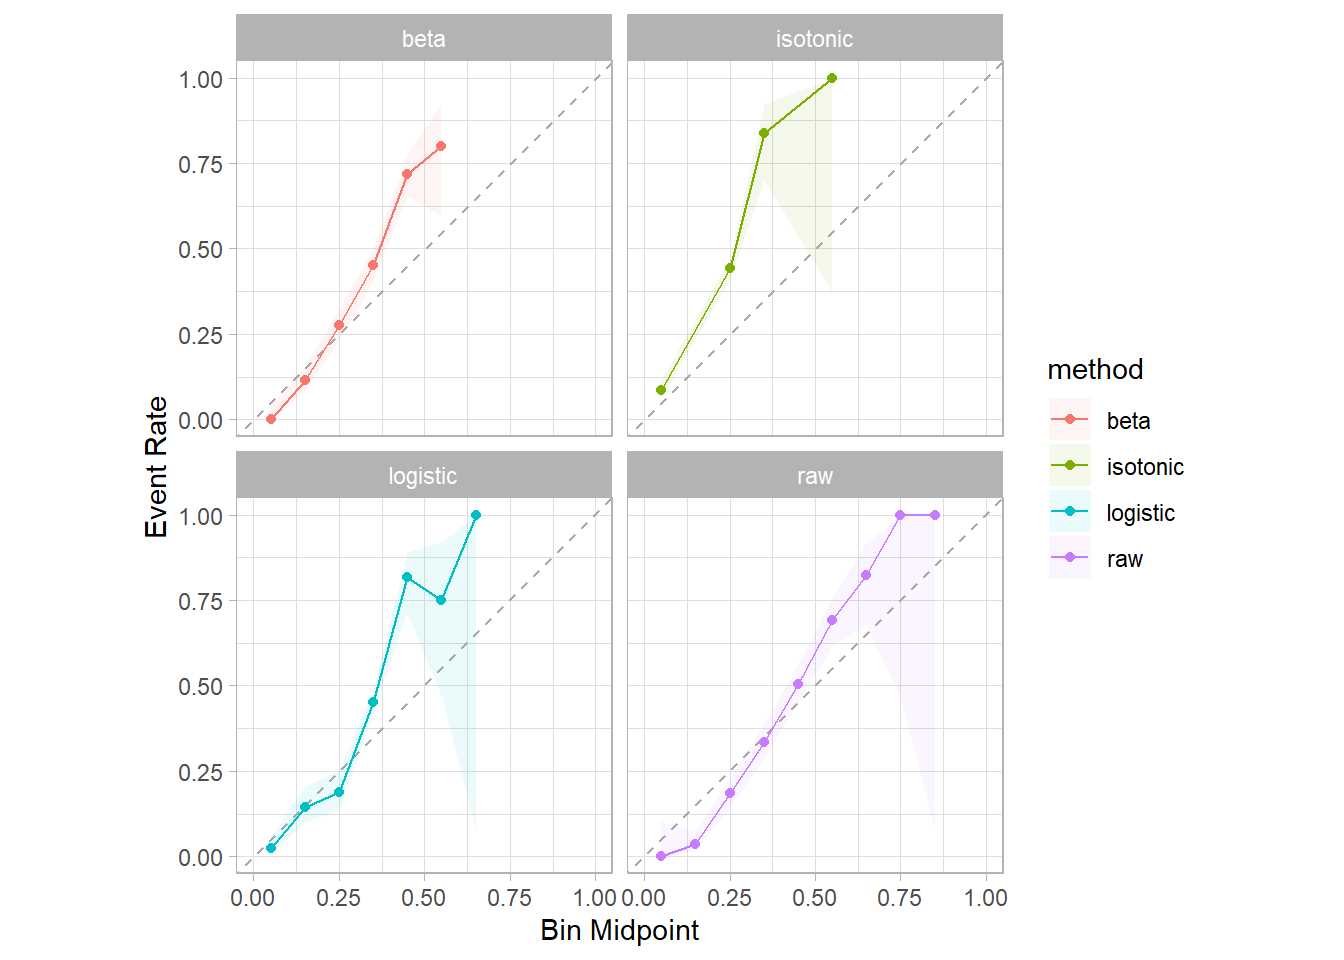

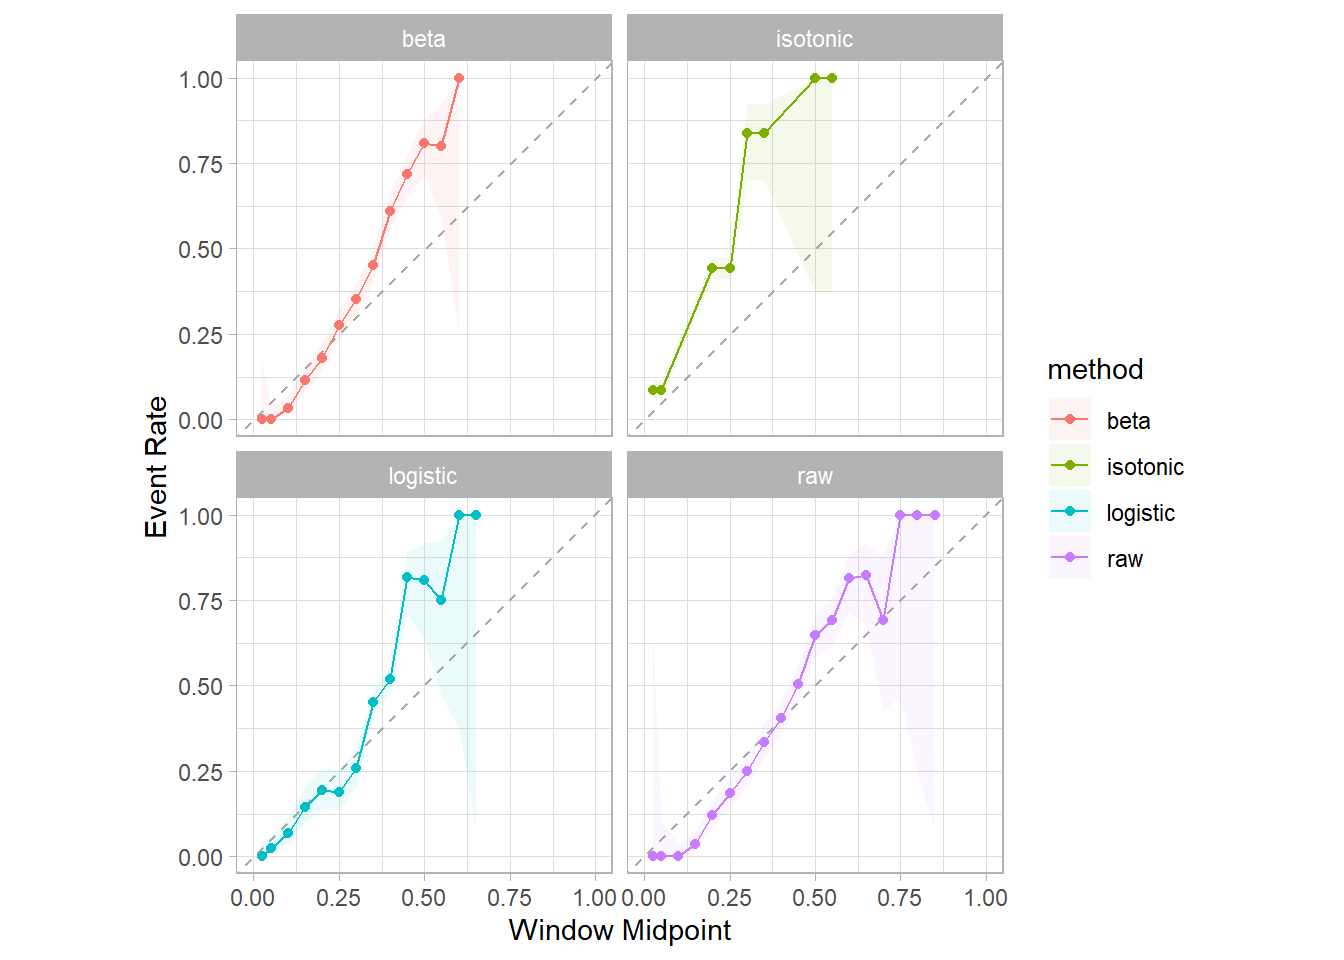

In [ ]:
d_plot |> 
  cal_plot_breaks(truth = outcome_rct_wk4, 
                  estimate = .pred_abstinent,
                  .by = method)


Raw probabilities appear the most well-calibrated: best aligned with diagonal line, spans the fullest range of bins/windows. Will use raw probabilities for AIM 2 analyses (selected above).